# Bonus-track Assignment 1: Mackey-Glass 17 task
## RNN
Note: as a reference for keras tuner I used the documentation: https://www.tensorflow.org/tutorials/keras/keras_tuner

In [16]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import keras_tuner as kt
import pandas as pd

### Load the dataset

In [3]:
#load the data
data = np.loadtxt("MG17.csv", delimiter=",")

#organize input and target 
x = data[:-1]
y = data[1:]
print(data)

[ 0.032164  0.040426  0.057861 ... -0.19556  -0.1368   -0.082192]


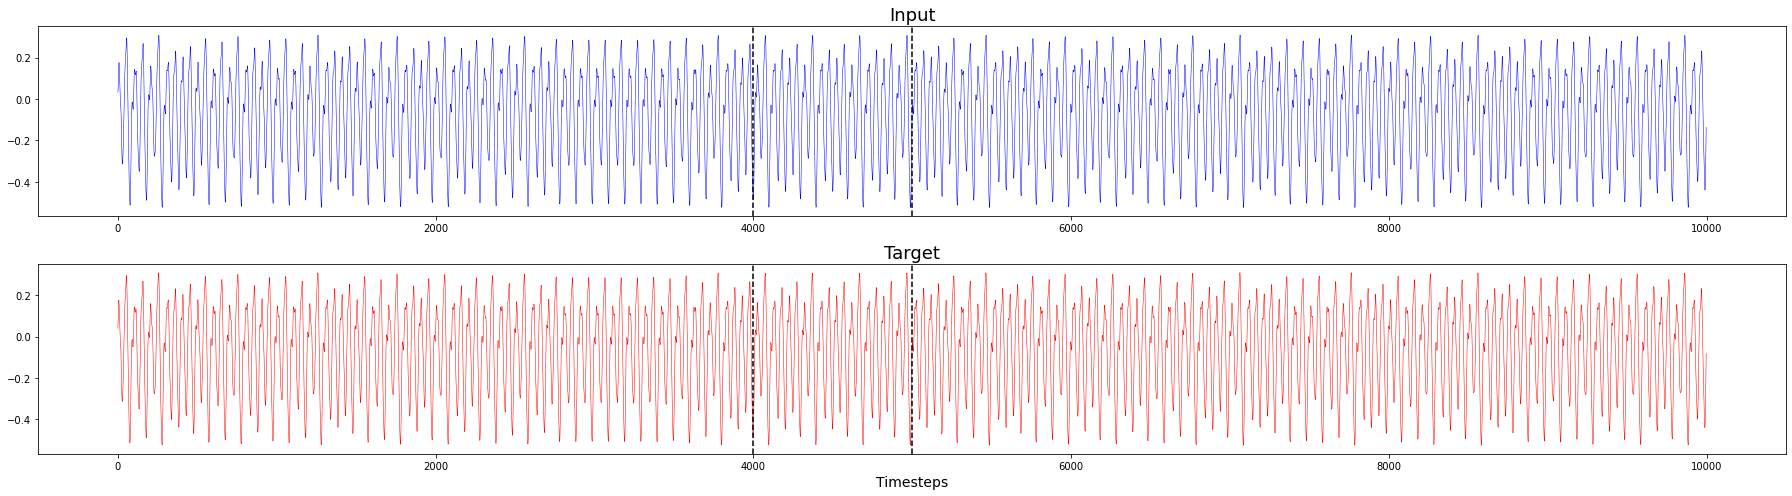

In [4]:
#split the dataset into training, validation and test
x_train = x[:4000]
x_valid = x[4000:5000] #validation
x_test = x[5000:]

y_train = y[:4000]
y_valid = y[4000:5000]
y_test = y[5000:]

#plot the data
t=np.arange(start=0,stop=len(x), step=1)
plt.figure(figsize = (25,7))
ax1 = plt.subplot(211)
plt.title('Input', fontsize=18)
ax1.plot(t,x, color = 'b', linewidth= 0.5)
ax1.axvline(x = 4000, color = 'black', linestyle= '--')
ax1.axvline(x = 5000, color = 'black', linestyle= '--')

ax2 = plt.subplot(212, sharex = ax1)
plt.title('Target', fontsize=18)
ax2.plot(t,y, color = 'r', linewidth = 0.5)
ax2.axvline(x = 4000, color = 'black', linestyle= '--')
ax2.axvline(x = 5000, color = 'black', linestyle= '--')
plt.xlabel('Timesteps', fontsize=14)
plt.tight_layout()

In [5]:
#size of the window we use to buffer the input
window_size = 17 #fix this value at 10 since we know it's the optimal value from theory

Prepare the dataset to implement the tdnn:

In [6]:
# Prepare the input X and target Y in order to implement the tdnn
def get_XY(x, y, window):
    # Remove the first "window" elements from y array
    Y = y[window:]
    # X will be an array containing "len(Y)" arrays created using the sliding window
    X = []
    rows_x = len(Y)
    j = 0
    for i in range(rows_x):
        X = np.append(X,x[j:j+window])
        j = j + 1

    #reshape X so it can be fed to the Dense layer
    X =  np.reshape(X, (rows_x, 1, window)) 
    return X, Y 


#prepare the data
trainX, trainY = get_XY(x_train, y_train, window_size)
validX, validY = get_XY(x_valid, y_valid, window_size)
testX, testY = get_XY(x_test, y_test, window_size)

#check shape
print(trainX.shape,trainY.shape)

(3983, 1, 17) (3983,)


### Create the model
To do model selection, we actually create the "hypermodel", defining the hyperparameter search space as well as the architecture of the model.

In [7]:
def model_architecture(hidden_units, activation_h, activation_d, lr):
    model = Sequential()
    input_shape = (1, window_size) 
    model.add(Dense(units=hidden_units,input_shape=input_shape, activation=activation_h))
    model.add(Dense(units=1, activation=activation_d))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=lr),metrics=['mean_squared_error'])
    return model


def create_model(hp):

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 10-250
    hidden_units = hp.Int('units',  min_value=10, max_value=250, step=10)

    #Tune the activation function of the hidden layer
    activation_h = hp.Choice("activation_h", ["linear","relu", "tanh"])
    #Tune the activation function of the last layer
    activation_d = hp.Choice("activation_d", ["linear","relu"])

    # Tune the learning rate for the optimizer
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


    # call model-building code with the hyperparameter values.
    model = model_architecture(
        hidden_units=hidden_units, activation_d=activation_d, activation_h=activation_h, lr=lr
    )
    return model


Instantiate hyperparameter tuner

In [8]:
# use random search to find optimal hyperparameters
tuner = kt.RandomSearch(
                     hypermodel =create_model,
                     objective='val_mean_squared_error',
                     max_trials=25,
                     #overwrite=True,
                     directory='tuner',
                     project_name='tuner_tdnn'
                     )

tuner.search_space_summary()

INFO:tensorflow:Reloading Tuner from tuner/tuner_tdnn/tuner0.json
Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 250, 'step': 10, 'sampling': 'linear'}
activation_h (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu', 'tanh'], 'ordered': False}
activation_d (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'relu'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


Create a callback to stop training early after reaching a certain value for the validation loss.

In [9]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [10]:
tuner.search(trainX, trainY, epochs=20, batch_size=1, validation_data = (validX, validY), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Completed hyperparameters search.\n
Otimal number of units of hidden layer = {best_hps.get('units')} \n
Optimal learning rate for the optimizer = {best_hps.get('learning_rate')} \n
Optimal activation function for the hidden layer = {best_hps.get('activation_h')} \n
Optimal activation function for the dense layer = {best_hps.get('activation_d')}
""")


INFO:tensorflow:Oracle triggered exit

Completed hyperparameters search.

Otimal number of units of hidden layer = 110 

Optimal learning rate for the optimizer = 0.0001 

Optimal activation function for the hidden layer = relu 

Optimal activation function for the dense layer = linear



Find the optimal number of epochs

In [11]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
model.summary()
history = model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2, validation_data = (validX, validY))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 110)            1980      
                                                                 
 dense_1 (Dense)             (None, 1, 1)              111       
                                                                 
Total params: 2,091
Trainable params: 2,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
3983/3983 - 10s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 1.6078e-04 - val_mean_squared_error: 1.6078e-04 - 10s/epoch - 2ms/step
Epoch 2/50
3983/3983 - 8s - loss: 6.9155e-05 - mean_squared_error: 6.9155e-05 - val_loss: 5.6421e-05 - val_mean_squared_error: 5.6421e-05 - 8s/epoch - 2ms/step
Epoch 3/50
3983/3983 - 9s - loss: 3.2847e-05 - mean_squared_error: 3.2847e-05 - val_loss: 2.5565e-05 - val_mean_squared_error: 2.5565e-0

Find best epoch:

In [12]:
val_mse_per_epoch = history.history['val_mean_squared_error']
best_epoch = val_mse_per_epoch.index(min(val_mse_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 37


Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

In [13]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(trainX, trainY, epochs=best_epoch, batch_size=1, validation_data = (validX, validY)).history

Epoch 1/37
3983/3983 [==============================] - 10s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 2.0462e-04 - val_mean_squared_error: 2.0462e-04
Epoch 2/37
3983/3983 [==============================] - 9s 2ms/step - loss: 1.0006e-04 - mean_squared_error: 1.0006e-04 - val_loss: 5.6967e-05 - val_mean_squared_error: 5.6967e-05
Epoch 3/37
3983/3983 [==============================] - 9s 2ms/step - loss: 3.6519e-05 - mean_squared_error: 3.6519e-05 - val_loss: 5.0710e-05 - val_mean_squared_error: 5.0710e-05
Epoch 4/37
3983/3983 [==============================] - 9s 2ms/step - loss: 2.2061e-05 - mean_squared_error: 2.2061e-05 - val_loss: 2.2216e-05 - val_mean_squared_error: 2.2216e-05
Epoch 5/37
3983/3983 [==============================] - 8s 2ms/step - loss: 1.6170e-05 - mean_squared_error: 1.6170e-05 - val_loss: 1.0110e-05 - val_mean_squared_error: 1.0110e-05
Epoch 6/37
3983/3983 [==============================] - 8s 2ms/step - loss: 1.2248e-05 - mean_squared_error

### Make plots of the loss and validation loss

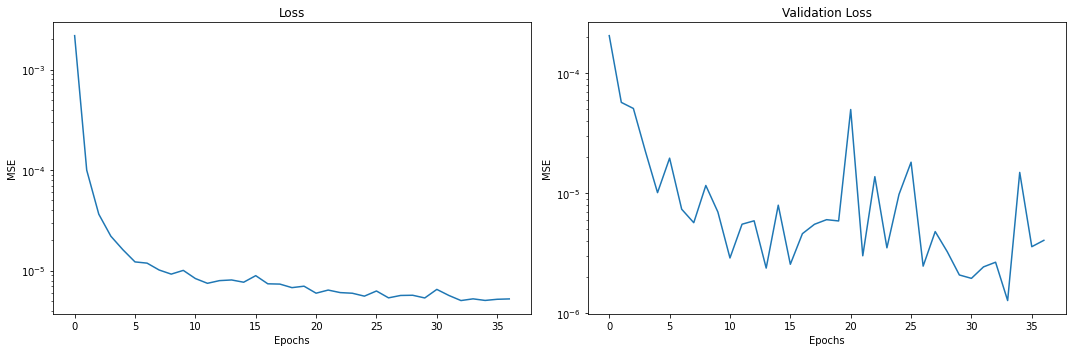

In [14]:
plt.figure(figsize = (15,5))

plt.subplot(121)
plt.plot(history['loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.yscale('log')

plt.subplot(122)
plt.plot(history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.yscale('log')
plt.tight_layout()

plt.savefig("plots/tdnn_loss.pdf")
plt.show()

Save history data

In [17]:
hist_df = pd.DataFrame(history) 
# save to json:  
hist_json_file = f'history_RNN.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

To load history data use:

In [18]:
#history = pd.read_json('history_RNN.json')

Save the model

In [19]:
hypermodel.save('keras_model_tdnn')

2023-05-12 11:55:34.985270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_2_input' with dtype float and shape [?,1,17]
	 [[{{node dense_2_input}}]]
2023-05-12 11:55:35.022546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_2_input' with dtype float and shape [?,1,17]
	 [[{{node dense_2_input}}]]
2023-05-12 11:55:35.037112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1,17]
	 [[{{n

INFO:tensorflow:Assets written to: keras_model_tdnn/assets


INFO:tensorflow:Assets written to: keras_model_tdnn/assets


Command to (eventually) load the saved model:

In [20]:
#hypermodel = keras.models.load_model('keras_model_tdnn')

### Plots of target and output signals over time

4982/4982 [==============================] - 7s 1ms/step - loss: 4.1260e-06 - mean_squared_error: 4.1260e-06


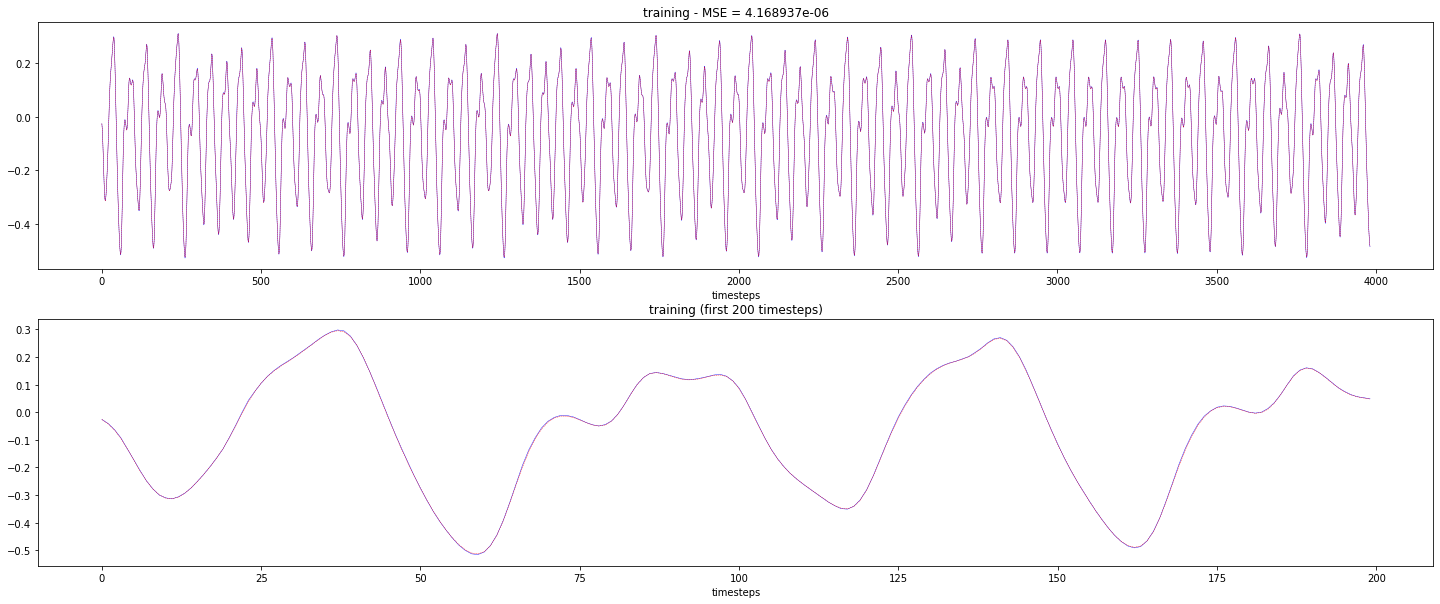

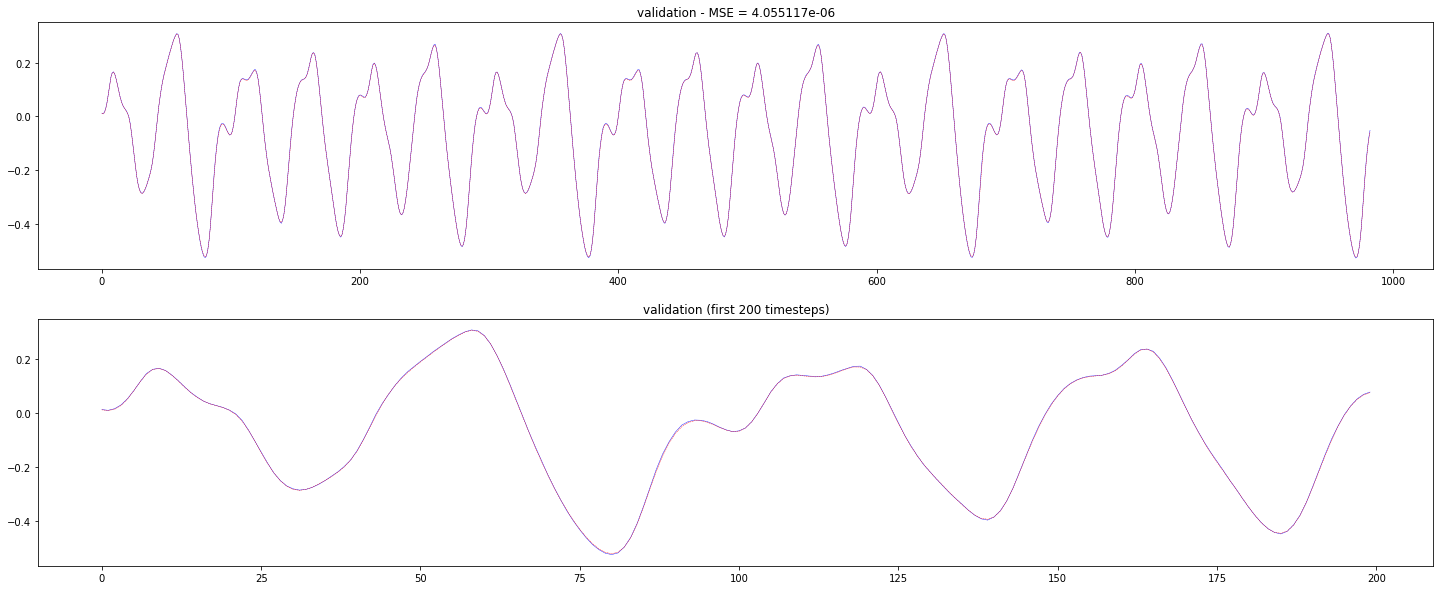

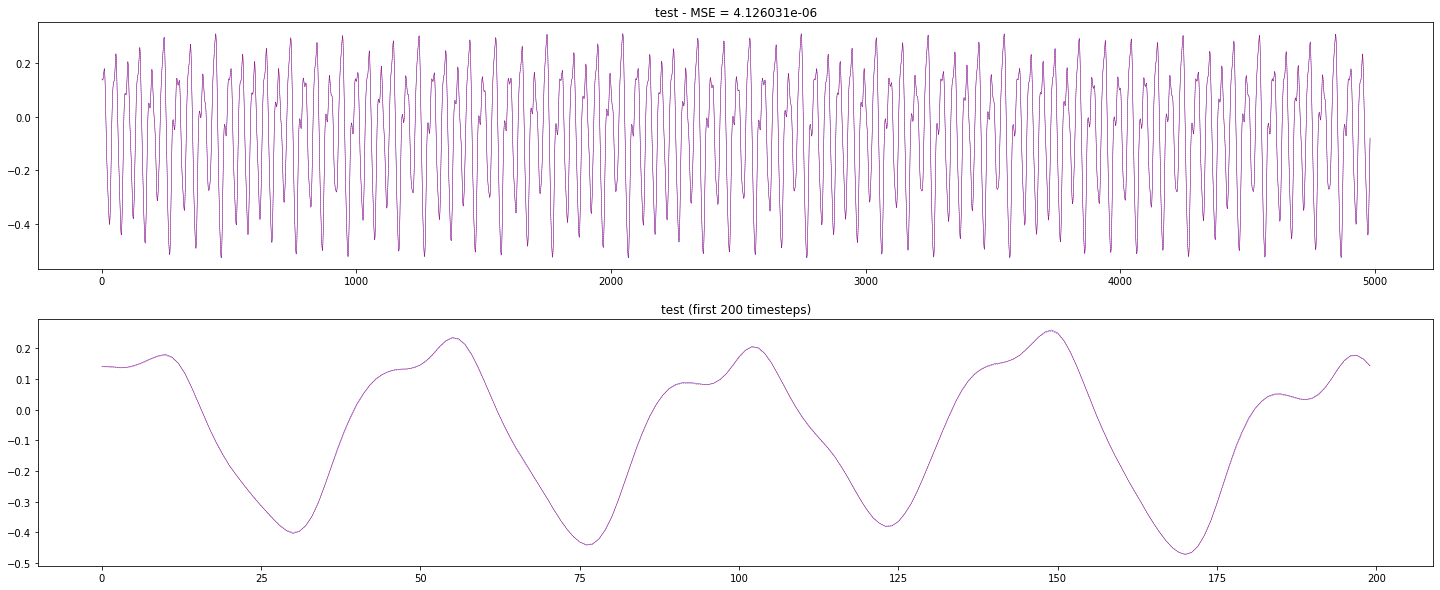

In [21]:
#training
y = hypermodel.predict(trainX)
mse = hypermodel.evaluate(trainX, trainY, batch_size=1)[0]
t=np.arange(start=0,stop=len(y), step=1)
plt.figure(figsize = (25,10))
plt.subplot(211)
plt.title(f'training - MSE = {mse:e}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t,trainY.ravel(), color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')
plt.xlabel('timesteps')

plt.subplot(212)
plt.title('training (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t[:200],trainY.ravel()[:200], color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')
plt.xlabel('timesteps')
plt.savefig("plots/tdnn_training.pdf")

#validation
y = hypermodel.predict(validX)
mse = hypermodel.evaluate(validX, validY, batch_size=1)[0]
t=np.arange(start=0,stop=len(y), step=1)
plt.figure(figsize = (25,10))
plt.subplot(211)
plt.title(f'validation - MSE = {mse:e}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t,validY.ravel(), color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')

plt.subplot(212)
plt.title('validation (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t[:200],validY.ravel()[:200], color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')
plt.savefig("plots/tdnn_validation.pdf")

#test
y = hypermodel.predict(testX)
mse = hypermodel.evaluate(testX, testY, batch_size=1)[0]
t=np.arange(start=0,stop=len(y), step=1)
plt.figure(figsize = (25,10))
plt.subplot(211)
plt.title(f'test - MSE = {mse:e}')
plt.plot(t,y.ravel(), color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t,testY.ravel(), color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')

plt.subplot(212)
plt.title('test (first 200 timesteps)')
plt.plot(t[:200],y.ravel()[:200], color = 'b', linewidth= 0.4, label = 'output')
plt.plot(t[:200],testY.ravel()[:200], color = 'r', linewidth= 0.4, linestyle = '--', label = 'target')
plt.savefig("plots/tdnn_test.pdf")
